In [1]:
!pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 8.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 25.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 32.6 MB/s eta 0:00:00


In [2]:
!pip install uproot awkward vector numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [9]:
import uproot
import awkward as ak
import numpy as np

# ===============================
# CONFIG
# ===============================
INPUT_ROOT  = "/kaggle/input/cms2011b-requiredbranches/merged.root"
OUTPUT_ROOT = "stageG_vertex_pileup.root"

# ===============================
# OPEN FILE
# ===============================
tree = uproot.open(INPUT_ROOT)["Events"]
branches = tree.keys()

# ===============================
# HELPERS
# ===============================
def find_branch_contains(prefix, contains):
    for b in branches:
        if b.startswith(prefix) and contains in b:
            return b
    raise RuntimeError(f"Missing branch: {prefix}*{contains}")

# ===============================
# PRIMARY VERTEX
# ===============================
PV = "recoVertexs_offlinePrimaryVertices__RECO"

b_pv_z = find_branch_contains(PV, "position_.fCoordinates.fZ")
b_pv_ndof = find_branch_contains(PV, "ndof_")

# ===============================
# RHO (SCALAR DOUBLE)
# ===============================
b_rho = None
for b in branches:
    if b.startswith("double_fixedGridRhoFastjetAll__RECO"):
        b_rho = b
        break

if b_rho is None:
    for b in branches:
        if b.startswith("double_fixedGridRhoAll__RECO"):
            b_rho = b
            break

if b_rho is None:
    raise RuntimeError("❌ Rho branch not found")

print("✔ Rho branch:", b_rho)

# ===============================
# LOAD ARRAYS
# ===============================
arrays = tree.arrays(
    [b_pv_z, b_pv_ndof, b_rho],
    library="ak"
)

# ===============================
# nPV
# ===============================
nPV = ak.num(arrays[b_pv_z], axis=1)

# ===============================
# LEADING PV
# ===============================
PV_z = ak.where(
    nPV > 0,
    arrays[b_pv_z][:, 0],
    0.0
)

PV_ndof = ak.where(
    nPV > 0,
    arrays[b_pv_ndof][:, 0],
    0.0
)

# ===============================
# RHO
# ===============================
rho = arrays[b_rho]

# ===============================
# ROOT-SAFE OUTPUT
# ===============================
def to_root(x):
    return np.asarray(ak.fill_none(x, 0.0), dtype=np.float32)

out = {
    "nPV":     to_root(nPV),
    "PV_z":    to_root(PV_z),
    "PV_ndof": to_root(PV_ndof),
    "rho":     to_root(rho),
}

# ===============================
# WRITE ROOT
# ===============================
with uproot.recreate(OUTPUT_ROOT) as fout:
    fout["Events"] = out

print(f"\n✅ Stage-G Vertex & Pileup ROOT written → {OUTPUT_ROOT}")


✔ Rho branch: double_fixedGridRhoAll__RECO./double_fixedGridRhoAll__RECO.obj


/tmp/ipykernel_47/1940962369.py:104: FutureWarning: Starting in version 5.7.0, Uproot will default to writing RNTuples instead of TTrees. You will need to use `mktree` to explicitly create a TTree. This can be done by changing `file['tree_name'] = data` to `file.mktree('tree_name', data)`. Please update your code accordingly.
  fout["Events"] = out



✅ Stage-G Vertex & Pileup ROOT written → stageG_vertex_pileup.root



Total events: 452055
Available branches: ['nPV', 'PV_z', 'PV_ndof', 'rho']

Basic stats:
nPV      min/max: 1.0 46.0
PV_z     min/max: -35.64622 38.638165
PV_ndof  min/max: 0.0 462.96484
rho      min/max: 0.0 39.344597

Physics sanity checks:
nPV < 0 events: 0
|PV_z| > 50 cm: 0
PV_ndof < 0: 0
rho < 0: 0

Valid vertex events: 431096


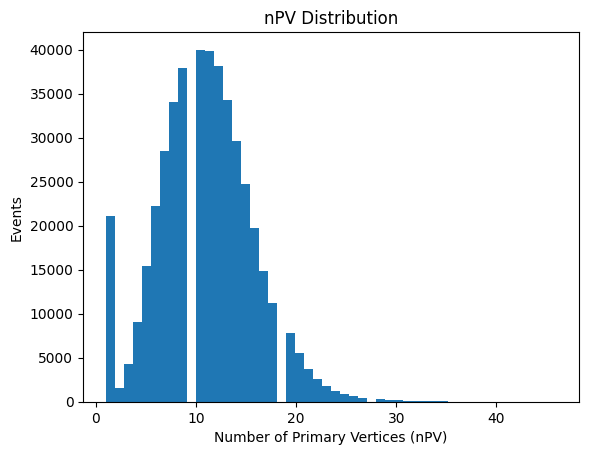

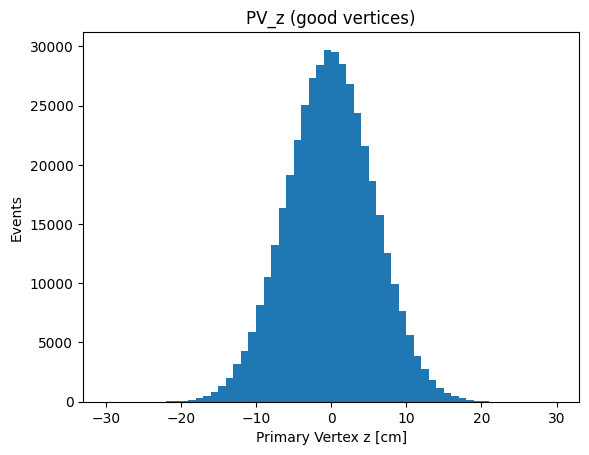

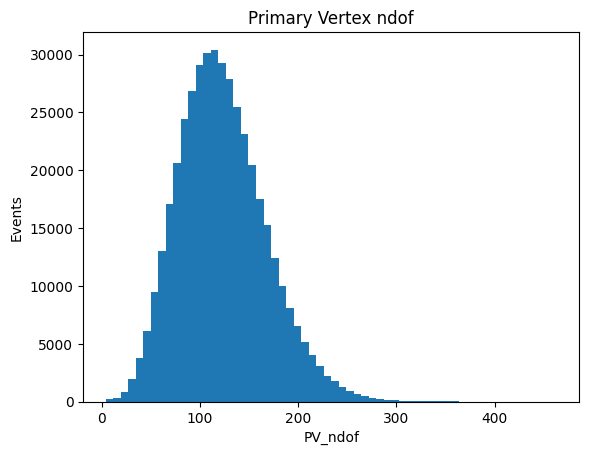

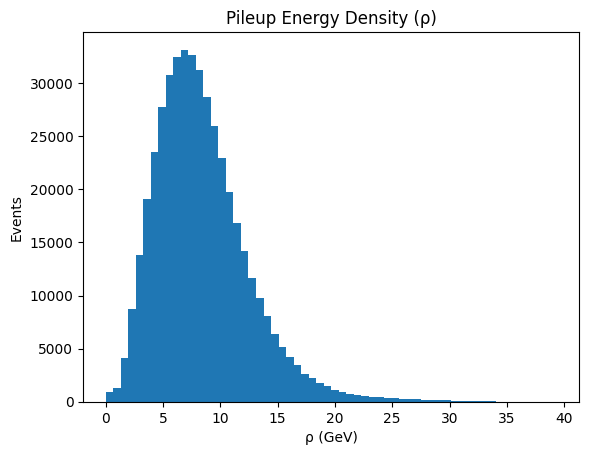

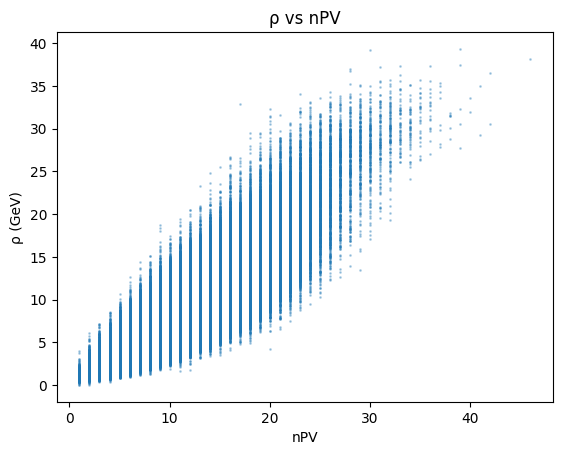


High pileup events (rho > 20): 6778
[{nPV: 19, rho: 22.5, PV_z: -3.44}, ..., {nPV: 23, rho: 26.2, PV_z: -3.73}]

✔ Stage-G EDA complete.


In [10]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# LOAD ROOT FILE
# ===============================
FILE = "/kaggle/working/stageG_vertex_pileup.root"
tree = uproot.open(FILE)["Events"]
arr = tree.arrays(library="ak")

print("\nTotal events:", len(arr))
print("Available branches:", list(arr.fields))

# ===============================
# BASIC STATS
# ===============================
print("\nBasic stats:")
print("nPV      min/max:", ak.min(arr.nPV), ak.max(arr.nPV))
print("PV_z     min/max:", ak.min(arr.PV_z), ak.max(arr.PV_z))
print("PV_ndof  min/max:", ak.min(arr.PV_ndof), ak.max(arr.PV_ndof))
print("rho      min/max:", ak.min(arr.rho), ak.max(arr.rho))

# ===============================
# PHYSICS SANITY CHECKS
# ===============================
bad_nPV      = ak.sum(arr.nPV < 0)
bad_PV_z     = ak.sum(np.abs(arr.PV_z) > 50)
bad_PV_ndof  = ak.sum(arr.PV_ndof < 0)
bad_rho      = ak.sum(arr.rho < 0)

print("\nPhysics sanity checks:")
print("nPV < 0 events:", bad_nPV)
print("|PV_z| > 50 cm:", bad_PV_z)
print("PV_ndof < 0:", bad_PV_ndof)
print("rho < 0:", bad_rho)

# Valid physics mask
mask_phys = (
    (arr.nPV >= 1) &
    (np.abs(arr.PV_z) < 24) &
    (arr.PV_ndof >= 4) &
    (arr.rho >= 0)
)

print("\nValid vertex events:", ak.sum(mask_phys))

# ===============================
# DISTRIBUTIONS
# ===============================
plt.figure()
plt.hist(ak.to_numpy(arr.nPV), bins=50)
plt.xlabel("Number of Primary Vertices (nPV)")
plt.ylabel("Events")
plt.title("nPV Distribution")
plt.show()

plt.figure()
plt.hist(ak.to_numpy(arr.PV_z[mask_phys]), bins=60, range=(-30, 30))
plt.xlabel("Primary Vertex z [cm]")
plt.ylabel("Events")
plt.title("PV_z (good vertices)")
plt.show()

plt.figure()
plt.hist(ak.to_numpy(arr.PV_ndof[mask_phys]), bins=60)
plt.xlabel("PV_ndof")
plt.ylabel("Events")
plt.title("Primary Vertex ndof")
plt.show()

plt.figure()
plt.hist(ak.to_numpy(arr.rho), bins=60)
plt.xlabel("ρ (GeV)")
plt.ylabel("Events")
plt.title("Pileup Energy Density (ρ)")
plt.show()

# ===============================
# CORRELATIONS
# ===============================
plt.figure()
plt.scatter(
    ak.to_numpy(arr.nPV[mask_phys]),
    ak.to_numpy(arr.rho[mask_phys]),
    s=1,
    alpha=0.3
)
plt.xlabel("nPV")
plt.ylabel("ρ (GeV)")
plt.title("ρ vs nPV")
plt.show()

# ===============================
# EDGE CASE INSPECTION
# ===============================
high_pu = arr.rho > 20
print("\nHigh pileup events (rho > 20):", ak.sum(high_pu))

if ak.sum(high_pu) > 0:
    print(
        ak.zip({
            "nPV": arr.nPV[high_pu][:5],
            "rho": arr.rho[high_pu][:5],
            "PV_z": arr.PV_z[high_pu][:5],
        })
    )

print("\n✔ Stage-G EDA complete.")
